# Initial data aqcuisition summary figure

This notebook is used for producing a summary figure created from the bias-corrected CORDEX data provided to Two Bears Environmental Consulting (via KR at SNAP) by Stantec, Inc. The purpose of this figure is for inclusion in a progress report (~8 June) being prepared by John Walsh.

### Specs

Here are the requested specs for this figure:

- Bar charts showing 99th percentiles of precipitation over all decades for available data
- doesn't matter what model, but do RCP 8.5 for future scenario (include RCP 4.5 if feasible)
- do this for Fairbanks and Dillingham (or other "urban" and "village" options if needed)

## Processing

Read the environment variables and set up directories:

In [1]:
import os
from pathlib import Path


# directory containing the bias corrected data
base_dir = Path(os.getenv("BASE_DIR"))
# write to the final_products/auxiliary_content directory, as the outputs from here will be used for reporting
out_dir = Path(os.getenv("OUTPUT_DIR")).joinpath("auxiliary_content")

hist_fp = base_dir.joinpath("arc_cordex/bias_corrected/hist/pr/ARC44_hist_pr_NCC-NorESM1-M_SMHI-RCA4_ERA5bc.nc")
rcp_fp = base_dir.joinpath("arc_cordex/bias_corrected/rcp85/pr/ARC44_rcp85_pr_NCC-NorESM1-M_SMHI-RCA4_ERA5bc.nc")

Set the coordinates of the two point locations to be used for grid cell extractions:

- Fairbanks: 64.8401° N, 147.7200° W
- Dillingham: 59.0395° N, 158.4633° W

In [2]:
coords = {
    "Fairbanks": (-147.72, 64.8401),
    "Dillingham (Curyung)": (-158.4633, 59.0395),
}

Define a function that will open a precipitation file and make a point extraction for a supplied percentile for a list of decades, supplied as a list of integers corresponding to the beginning year of the decades:

In [3]:
import numpy as np
import xarray as xr


def extract_percentile(fp, q, lon, lat, years):
    decades = [
        slice(
            f"{year}-01-01", 
            f"{year + 9}-12-31", 
        )
        for year in years
    ]

    with xr.open_dataset(fp) as ds:
        point_da = ds["pr"].sel(lon=lon, lat=lat, method="nearest")
        out_arr = np.array([
            np.percentile(point_da.sel(time=decade).values, q)
            for decade in decades
        ])
        
    return out_arr

Define a function to create the desired plot for a given location:

In [4]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt


def create_barplot(hist_fp, rcp_fp, location, out_fp):
    # makes use of the global "coords" dict
    # ignore futurewarning caused by xarray ds.loc
    #warnings.simplefilter(action='ignore', category=FutureWarning)
    
    decades = [f"{year}-{year + 9}" for year in np.arange(1980, 2101, 10)]
    
    df_list = []
    for q in [99, 99.9]:
        hist_arr = extract_percentile(hist_fp, q, *coords[location], [1980, 1990, 2000])
        rcp_arr = extract_percentile(rcp_fp, q, *coords[location], np.arange(2000, 2101, 10))
        # take mean of historical and projected values for 2000-2009 decade
        hist_arr[-1] = (hist_arr[-1] + rcp_arr[0]) / 2
        # drop 2000's value from rcp array
        combined = np.concatenate([hist_arr, rcp_arr[1:]])
        for i, decade in zip(combined, decades):
            df_list.append([q, decade, i * 8640])
        
    df = pd.DataFrame(df_list, columns=["Percentile", "Decade", "Precipitation"])

    ax = df.pivot("Decade", "Percentile", "Precipitation").plot(kind="bar", figsize=(15, 8), rot=0)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(15)
    
    plt.ylabel("Precipitation (cm)", size=14)
    plt.xlabel("Decade", size=14)
    plt.title(
        (
            f"Extreme daily precipitation values by decade for {location}, Alaska,"
            "\nfrom NorESM1-M, RCP 8.5"
        ), size=14
    )
    plt.legend(title="Percentile", fontsize=14, title_fontsize=14)
    plt.savefig(out_fp)
    plt.show()

Create the plot for **Fairbanks**:

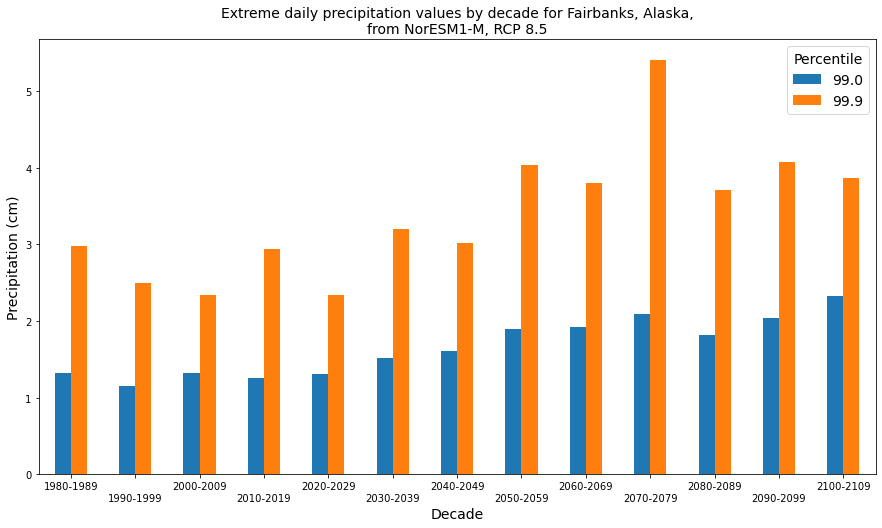

In [5]:
create_barplot(hist_fp, rcp_fp, "Fairbanks", out_dir.joinpath("initial_precip_summary_sample_Fairbanks.png"))

And **Dillingham**:

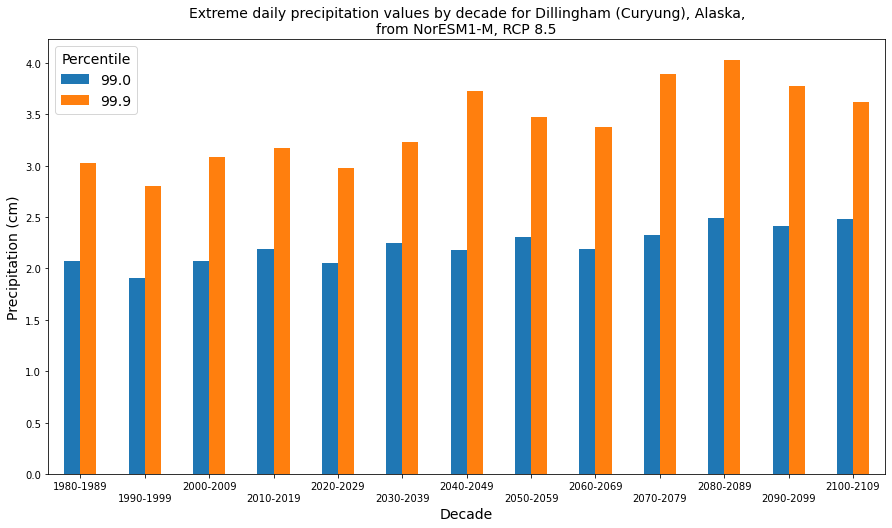

In [6]:
create_barplot(hist_fp, rcp_fp, "Dillingham (Curyung)", out_dir.joinpath("initial_precip_summary_sample_Dillingham.png"))

These files can then be copied to the project folder within the SNAP Team Drive for sharing, using e.g. RClone:

```sh
rclone copy initial_precip_summary_sample_Dillingham.png google-drive:Projects/TBEC\ CMIP5\ Processing
rclone copy initial_precip_summary_sample_Fairbanks.png google-drive:Projects/TBEC\ CMIP5\ Processing
```